In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    QuantileTransformer,
    RobustScaler,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    make_scorer,
    cohen_kappa_score,
)
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from imblearn import pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier

In [35]:
sns.set_theme()

colors = ["#19ae1d", "#e60c34", "#fda929"]
colors_w = ["#5798ff", "#c2006b"]

In [18]:
# Import the CSVs
wine = pd.read_csv('data/processed/wine.csv', sep=',')
rw = pd.read_csv('data/processed/red_wine_p.csv', sep=',')
ww = pd.read_csv('data/processed/white_wine_p.csv', sep=',')


In [32]:
# Convert 'wine type' to categorical data
wine['wine type'] = wine['wine type'].astype('category')
rw['quality label'] = wine['quality label'].astype('category')
ww['quality label'] = wine['quality label'].astype('category')

# Encode wine type into 1 and 0 
# enc = preprocessing.OneHotEncoder()
# enc_data = pd.DataFrame(enc.fit_transform(
#     wine[['wine type']]).toarray())
# data["wine type"].cat.codes


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       290
           1       0.99      0.99      0.99       774

    accuracy                           0.99      1064
   macro avg       0.99      0.98      0.98      1064
weighted avg       0.99      0.99      0.99      1064



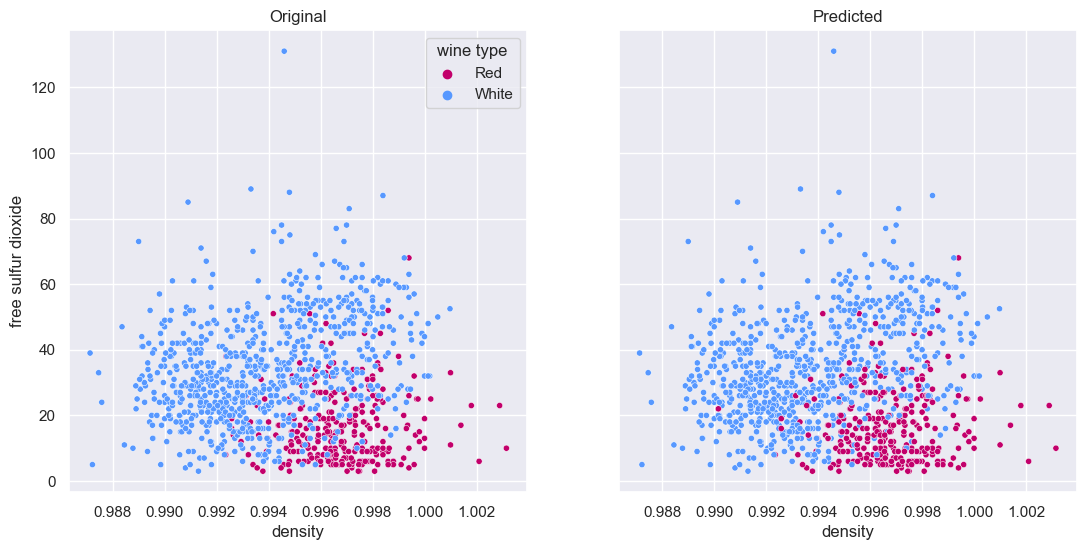

In [24]:
def predict_type(data):
    y = data["wine type"].cat.codes.copy()
    X = data.iloc[:, list(range(0, 8))].copy()
    # display(pd.concat([X, y], join='outer', axis=1))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipe = Pipeline([
            ("scaler", QuantileTransformer()),
            ("model", LogisticRegression(max_iter=1000)),
        ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    print(classification_report(pred, y_test))

    fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
    sns.scatterplot(
        x=data.iloc[:, 7],
        y=data.iloc[:, 5],
        hue=data["wine type"][y_test.index],
        ax=axes[0],
        palette=colors_w[::-1],
        s=20,
    )
    axes[0].set_title('Original')
    sns.scatterplot(
        x=X_test.iloc[:, 7],
        y=X_test.iloc[:, 5],
        hue=pred,
        ax=axes[1],
        palette=colors_w[::-1],
        s=20,
    )
    axes[1].set_title('Predicted')
    axes[1].legend([], [], frameon=False)

predict_type(wine)

In [37]:
def predict_quality(data, model, make_plot): 

    def custom_precision(y_true, y_pred):
        precision = precision_score(y_true, y_pred)
        return precision if not np.isnan(precision) else 0

    precision_scorer = make_scorer(precision_score)

    y = data['quality label'].cat.codes
    if data['wine type'][0] == 'Red':
        X = data[['alcohol', 'volatile acidity', 'citric acid', 'sulphates', ]]
        class_weight = {0: 3, 1: 1, 2: 2, 3: 1}
    else:
        X = data[['alcohol', 'volatile acidity', 'chlorides', 'density']]
        class_weight = {0: 3, 1: 2, 2: 2, 3: 2}
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=42)


    under = RandomUnderSampler()
    over = SMOTE(random_state=42)
    sampling_pipe = pipeline.Pipeline([
        ('over', over),
        ('under', under)
    ])
    X_train_resampled, y_train_resampled = sampling_pipe.fit_resample(X_train, y_train)

    param_grid = {}
    if model == 'svc':
        model = svm.SVC(class_weight=class_weight, gamma=10)
        param_grid = {'model__C': [5, 8, 10, 13, 15]}
    elif model == 'kn':
        model =  KNeighborsClassifier(n_neighbors=4)
        param_grid = {'model__n_neighbors': [4, 8, 12, 16], 
                      'model__weights': ['uniform', 'distance']}
    else:
        model =  RandomForestClassifier(random_state=42)

    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    grid = GridSearchCV(
                estimator=pipe,
                param_grid=param_grid,
                scoring=precision_scorer,
                return_train_score=True,
                cv=4,
                n_jobs=-1
    )
    pipe.fit(X_train_resampled, y_train_resampled)
    pred = pipe.predict(X_test)

    print(confusion_matrix(pred, y_test))
    print(classification_report(pred, y_test))
    # display(pd.DataFrame(grid.cv_results_))

    if make_plot:

        fig, axes = plt.subplots(1, 2, figsize = (12, 5), sharey=True)
        sns.scatterplot(
            y=data['alcohol'],
            x=data['volatile acidity'],
            hue=data["quality label"][y_test.index],
            palette=colors,
            ax=axes[0],
            s=25,
            linewidth=0,
        )
        axes[0].set_title('Original')
        sns.scatterplot(
            y=X_test['alcohol'],
            x=X_test['volatile acidity'],
            hue=pred,
            palette=colors,
            ax=axes[1],
            s=25,
            linewidth=0,
        )
        axes[1].set_title('Predicted')
        axes[1].legend([], [], frameon=False)


[[  0   3  33]
 [  2   2  51]
 [ 14  34 654]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.05      0.04      0.04        55
           2       0.89      0.93      0.91       702

    accuracy                           0.83       793
   macro avg       0.31      0.32      0.32       793
weighted avg       0.79      0.83      0.81       793



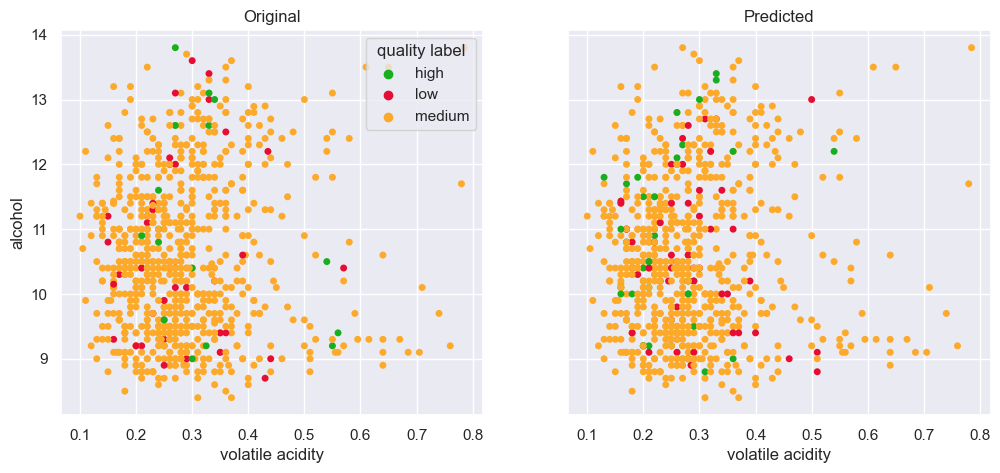

In [38]:
# predict_quality(ww, 'svc', True)
# predict_quality(rw, 'kn', True)
predict_quality(ww, 'r_forest', True)

In [ ]:
# 1. Optimize Notebooks (Split it into parts, save processed data to SCV) ✅
# 2. Minimize the under- and over- sampling
# 3. Check RandomSearch
# 4. Look into GradientBoost and XGBoost models

In [ ]:
# grid = GridSearchCV(
#                 estimator=pipe,
#                 param_grid={'model__n_neighbors': [4, 8, 12, 16],
#                             'model__algorithm': ['auto'],
#                             # 'model__weights': ['uniform', 'distance']
#                             },
#                 scoring=precision_scorer,
#                 # return_train_score=True,
#                 # refit=True,
#                 # cv=4,
#                 n_jobs=-1
# )

# pipe = Pipeline([
#     ('scaler', MinMaxScaler()),
#     ('model', KNeighborsClassifier())
# ])

# grid = GridSearchCV(estimator=pipe,
#                     param_grid={'model__n_neighbors': list(range(1, 10))},
#                     scoring='precision',
#                     refit=True,
#                     return_train_score=True,
#                     cv=10,
#                     n_jobs=-1
# )


# grid.fit(X_train, y_train)
# # display(pd.DataFrame(grid.cv_results_))

# # pipe.fit(X_train, y_train)
# pred = grid.predict(X_test)
# display(pd.DataFrame(grid.cv_results_))
# print(classification_report(pred, y_test))

# enc = LabelEncoder()
# enc_data = pd.DataFrame(enc.fit_transform(wine['quality label']))

# display(pd.concat([wine['quality label'], y], join='outer', axis=1)[1356:1380])

# mod = GridSearchCV(estimator=pipe,
#                    param_grid={'model__n_neighbors': [2, 3, 4, 5, 6, 20]},
#                    scoring={'precision': make_scorer(precision_score),
#                             'recall': make_scorer(recall_score),
#                             'min_both': make_scorer(min_r_p)},
#                    refit='min_both',
#                    return_train_score=True,
#                    cv=3,
#                    n_jobs=-1)

# svm.SVC(class_weight={0: 2, 1: 1, 2: 2})



# print(precision_score(pred, y_test))
# print(recall_score(pred, y_test))
# pd.DataFrame(mod.cv_results_)